In [23]:
!pip install datasets

In [24]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [25]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import transformers
import pandas as pd
from transformers import AutoModel
from transformers import BertForSequenceClassification

In [26]:
from datasets import load_dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6217
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 777
    })
})


In [27]:
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

# Convert the dataset to a list of dictionaries so train_test_split can be applied
train_data = dataset['train']

# Convert the dataset to a list of dicts (this step should be done carefully)
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split the train data into 90% for training and 10% for testing
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Clean function to preserve emojis and emoticons
def clean_text(text):
    # Remove unwanted characters but keep emojis and emoticons
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Keep only letters, numbers, whitespaces, and emojis
    text = re.sub(r'[^a-zA-Z0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', '', text)
    text = text.strip()
    return text

# Apply the cleaning function to the train, test, and validation datasets
train_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in train_data_split]
test_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in test_data_split]
dataset['validation'] = [{'text': clean_text(item['text']), 'label': item['label']} for item in dataset['validation']]

# Check the cleaned data
print(train_data_split[1])
print(test_data_split[0])
print(dataset['validation'][0])

{'text': 'Haha  nija', 'label': 0}
{'text': '', 'label': 0}
{'text': '100 days pakka', 'label': 0}


In [28]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

# Extract train data
train_data = dataset['train']

# Convert to a list of dictionaries for train_test_split
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split train data into 90% train and 10% test
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Convert lists of dictionaries to pandas DataFrames
df_train = pd.DataFrame(train_data_split)
df_test = pd.DataFrame(test_data_split)
df_val = pd.DataFrame([{'text': item['text'], 'label': item['label']} for item in dataset['validation']])

# Ensure the DataFrames contain the required columns
required_columns = ['text', 'label']
for df_name, df in zip(['df_train', 'df_test', 'df_val'], [df_train, df_test, df_val]):
    if not all(col in df.columns for col in required_columns):
        raise KeyError(f"{df_name} must contain the columns {required_columns}.")

# Function to extract emojis from the text
def extract_emojis(text):
    emoji_pattern = re.compile(
        r'[\U0001F600-\U0001F64F'  # emoticons
        r'\U0001F300-\U0001F5FF'  # symbols & pictographs
        r'\U0001F680-\U0001F6FF'  # transport & map symbols
        r'\U0001F700-\U0001F77F'  # alchemical symbols
        r'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        r'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        r'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        r'\U0001FA00-\U0001FA6F'  # Chess Symbols
        r'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        r'\U00002702-\U000027B0'  # Dingbats
        r'\U000024C2-\U0001F251'  # Enclosed characters
        r']+', flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return ''.join(emojis)

# Function to separate emojis and clean text
def separate_emojis(text):
    emojis = extract_emojis(text)
    # Remove emojis and keep only cleaned text
    text_without_emojis = re.sub(r'[^\w\s,\.!?]', '', text)
    return text_without_emojis.strip(), emojis

# Apply the cleaning and emoji extraction function
df_train['cleaned_text'], df_train['emojis'] = zip(*df_train['text'].map(separate_emojis))
df_test['cleaned_text'], df_test['emojis'] = zip(*df_test['text'].map(separate_emojis))
df_val['cleaned_text'], df_val['emojis'] = zip(*df_val['text'].map(separate_emojis))

# Create separate DataFrames for cleaned text and emojis with labels
df_cleaned_text_train = df_train[['cleaned_text', 'label']].copy()
df_emojis_train = df_train[['emojis', 'label']].copy()

df_cleaned_text_test = df_test[['cleaned_text', 'label']].copy()
df_emojis_test = df_test[['emojis', 'label']].copy()

df_cleaned_text_val = df_val[['cleaned_text', 'label']].copy()
df_emojis_val = df_val[['emojis', 'label']].copy()

# Display sample data
print("Cleaned Text Train Data:")
print(df_cleaned_text_train.head())

print("\nEmojis Train Data:")
print(df_emojis_train.head())

print("\nCleaned Text Test Data:")
print(df_cleaned_text_test.head())

print("\nEmojis Test Data:")
print(df_emojis_test.head())

print("\nCleaned Text Validation Data:")
print(df_cleaned_text_val.head())

print("\nEmojis Validation Data:")
print(df_emojis_val.head())

Cleaned Text Train Data:
                       cleaned_text  label
0                          Hands up      0
1                        Haha  nija      0
2                     1 in trending      5
3   Movie hindi me kb tk aa ne ka h      5
4  Edu charitre srustisuva avatraaa      0

Emojis Train Data:
  emojis  label
0             0
1             0
2             5
3             5
4             0

Cleaned Text Test Data:
                                        cleaned_text  label
0  ವವ ಸಪರ ಅನಲಸಸನಮಮ ದಶ ಓಳಳದ...ಮತ ಜಸತ  ಕಲಸ ಕಮಮ........      0
1  Yalla kannadigarugu ansthithu bere bashe movie...      0
2                   Sir make vidieo on drone prathap      5
3                          Vivek G side ge hogro nim      3
4   ಈ ಯಗದ ಶಕರ ನಗ ಗರ ನನ  all the best from DBOSS fans      0

Emojis Test Data:
  emojis  label
0             0
1             0
2             5
3             3
4             0

Cleaned Text Validation Data:
                                        cleaned_text  label
0         

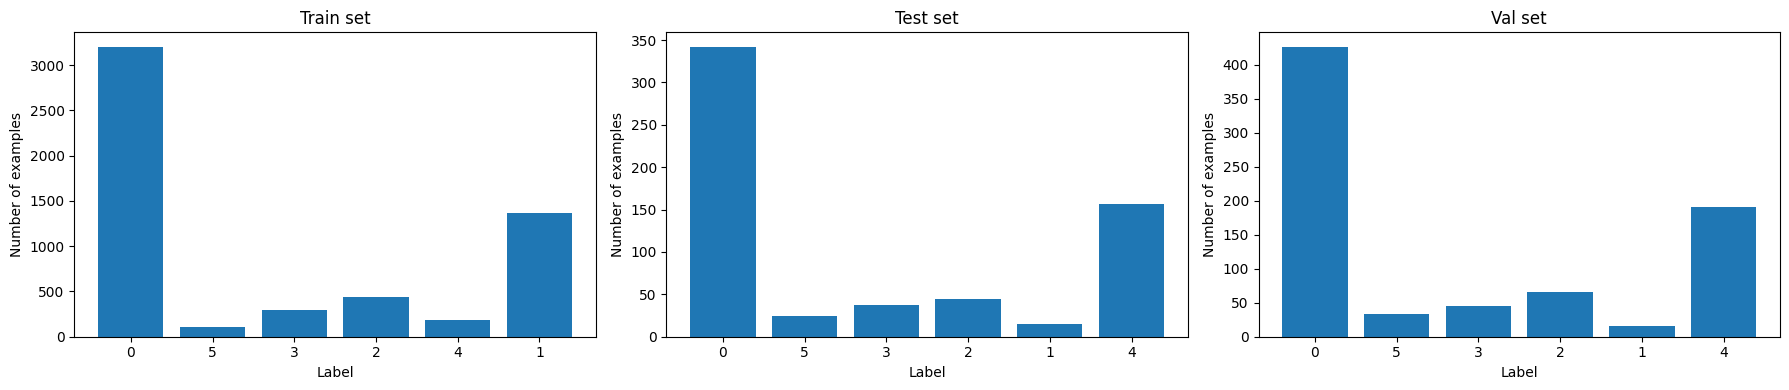

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting the distribution of labels in Train, Test, and Validation datasets
fig = plt.figure(figsize=(18, 4))
titles = ['Train set', 'Test set', 'Val set']

for i, dataf in enumerate([df_train, df_test, df_val]):
    ax = fig.add_subplot(1, 3, i+1)
    Y, labels = pd.factorize(dataf['label'])  # Ensure 'label' column is used
    ax.bar(labels, height=pd.Series(Y).value_counts())  # Bar plot for label count
    ax.set_xticks(ticks=range(len(labels)))  # Position the x-ticks
    ax.set_xticklabels(labels, fontsize=10)  # Set x-tick labels with font size
    ax.set_xlabel('Label')  # X-axis label
    ax.set_ylabel('Number of examples')  # Y-axis label
    ax.set_title(titles[i])  # Title for each plot

# Show the plots
plt.tight_layout()
plt.show()


In [30]:
# Number of samples in Train, Test, and Validation datasets
train_samples = len(df_train)
test_samples = len(df_test)
val_samples = len(df_val)

# Printing the number of samples
print(f"Number of samples in Train set: {train_samples}")
print(f"Number of samples in Test set: {test_samples}")
print(f"Number of samples in Validation set: {val_samples}")


Number of samples in Train set: 5595
Number of samples in Test set: 622
Number of samples in Validation set: 777


In [31]:
class TamilSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Access text and label directly (label is already an integer)
        text = self.data.iloc[idx]['cleaned_text']
        label = self.data.iloc[idx]['label']  # Integer label (0 to 5)

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Return tokenized data and the label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [32]:
model = BertForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=6)

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.lay

In [33]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(200000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [34]:
tokenizer = transformers.AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
tokenizer

AlbertTokenizerFast(name_or_path='ai4bharat/indic-bert', vocab_size=200000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [35]:
batch_size = 32
max_length = 128
epochs = 5
learning_rate = 3e-5


# Create dataloaders for training and validation
train_dataset = TamilSentimentDataset(df_cleaned_text_train, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TamilSentimentDataset(df_cleaned_text_val, tokenizer, max_length=128)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



train_dataset.__len__()

5595

In [36]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(200000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [38]:
from sklearn.metrics import f1_score

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            val_accuracy += (predicted == labels).sum().item()

            # Store predictions and labels for F1-score calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1-score
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch: {epoch + 1}, Train Loss: {running_loss / len(train_loader)}, "
          f"Val Loss: {val_loss / len(val_loader)}, "
          f"Val Accuracy: {val_accuracy / len(val_dataset):.4f}, "
          f"F1 Score: {f1:.4f}")


Epoch 1/5: 100%|██████████| 350/350 [02:17<00:00,  2.54it/s]


Epoch: 1, Train Loss: 1.0377409069878714, Val Loss: 0.9577495802421959, Val Accuracy: 0.6860, F1 Score: 0.6285


Epoch 2/5: 100%|██████████| 350/350 [02:18<00:00,  2.52it/s]


Epoch: 2, Train Loss: 0.8609099677630834, Val Loss: 0.8711821473374659, Val Accuracy: 0.7040, F1 Score: 0.6501


Epoch 3/5: 100%|██████████| 350/350 [02:18<00:00,  2.53it/s]


Epoch: 3, Train Loss: 0.7392921586121831, Val Loss: 0.8789609603735865, Val Accuracy: 0.6976, F1 Score: 0.6475


Epoch 4/5: 100%|██████████| 350/350 [02:18<00:00,  2.53it/s]


Epoch: 4, Train Loss: 0.6410619783827237, Val Loss: 0.8762822066034589, Val Accuracy: 0.7169, F1 Score: 0.6821


Epoch 5/5: 100%|██████████| 350/350 [02:18<00:00,  2.53it/s]


Epoch: 5, Train Loss: 0.5697837612245764, Val Loss: 0.8361363958339302, Val Accuracy: 0.7297, F1 Score: 0.6931


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            _, predicted = torch.max(logits, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}


In [40]:
val_accuracy = evaluate_model(model, val_loader, device)
print('Validation Accuracy:', val_accuracy)

train_accuracy = evaluate_model(model, train_loader, device)
print('Training Accuracy:', train_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: {'accuracy': 0.7297297297297297, 'precision': 0.6669570017248486, 'recall': 0.7297297297297297, 'f1_score': 0.6931132183001901}
Training Accuracy: {'accuracy': 0.8575513851653261, 'precision': 0.8091923121690743, 'recall': 0.8575513851653261, 'f1_score': 0.8315848713470755}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
def predict_sentiment(model, tokenizer, text, max_length, device):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    sentiment = [key for key, value in label_map.items() if value == predicted_label][0]
    return sentiment